<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/DNN/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install inltk
!pip install nepali-stemmer

In [3]:
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
from nepali_stemmer.stemmer import NepStemmer
# setup('ne')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# from google.colab import files
# uploaded = files.upload()
df = pd.read_csv('QSN.csv')

['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


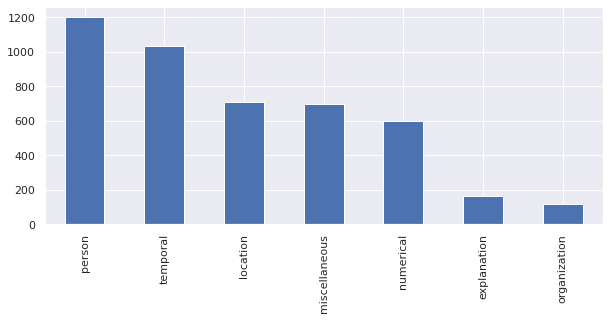

In [28]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [29]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [31]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [32]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  # questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [ ]:
#stemmig
# nepstem = NepStemmer()
# df['Questions'] = df['Questions'].apply(nepstem.stem)
# df.head(10)

In [33]:
df['Questions'] = preprocessing(df['Questions'])

dataset=df

df.head()

,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स को लियोन सम्पन्न महिला विश्वकप फुटबल २...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल को बोट रु दश नोट कार्यक्रमको सुरुवात कुन...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना को विध...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


*The topology of a neural network that classifies text is somewhat different than that of the networks presented thus far. It still has a dense layer (or layers), and it still has a sigmoid output layer with one neuron for binary classification or a softmax output layer with one neuron per class for multiclass classification. But preceding those layers are an embedding layer and a flatten layer. The former uses word embeddings to transform arrays, or sequences, of scalar values representing words into arrays of word vectors, which encode information about relationships between words. The latter “flattens” the 2D arrays output by the embedding layer into 1D arrays that can be input to a dense layer.*

In [34]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'])
sequences = tokenizer.texts_to_sequences(df['Questions'])
# print(sequences)

*Neural network expects all sequences to be the same length. Keras’s pad_sequences function performs this final step, truncating sequences longer than the specified length and padding sequences shorter than the specified length with 0s:*

In [35]:
from keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, maxlen=100)
print(padded_sequences)

[[   0    0    0    0 ... 1118   98    3  218]
 [   0    0    0    0 ...   53    6   58  192]
 [   0    0    0    0 ...    7    4  417  140]
 [   0    0    0    0 ...    2 1289  228  968]
 ...
 [   0    0    0    0 ... 2132 3437   13  244]
 [   0    0    0    0 ...    7    4  354 5392]
 [   0    0    0    0 ...    4  527  137 1160]
 [   0    0    0    0 ...    4  527  137 1160]]


*The first hidden layer in a neural network that classifies text is an embedding layer whose job is to convert padded sequences of word indices into arrays of word vectors, which represent each word with an array of floating-point numbers rather than a single integer. Each word in the input text is represented by a vector in the embedding layer, and as the network is trained, vectors representing individual words are adjusted to reflect their relationship to one another. If you’re building a sentiment-analysis model and words such as “excellent” and “amazing” are generally associated with positive sentiment, then the vectors representing those words in the embedding space should be relatively close together so phrases such as “excellent service” and “amazing service” score similarly*

**One hot encoding of labels**

In [150]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
y=df.CoarseType;
print(y.unique())
y = le.fit_transform(y)
y = to_categorical(y) 

['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


**Coarse Grained Classification**

In [275]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
model = Sequential() 
model.add(Embedding(10000, 32, input_length=100)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()
x=padded_sequences;
# Splitting test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20) 
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=22)


Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_143 (Embedding)   (None, 100, 32)           320000    
                                                                 
 flatten_137 (Flatten)       (None, 3200)              0         
                                                                 
 dense_280 (Dense)           (None, 128)               409728    
                                                                 
 dense_281 (Dense)           (None, 7)                 903       
                                                                 
Total params: 730,631
Trainable params: 730,631
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
165/165 [==============================] - 2s 12ms/step - loss: 1.4431 - categorical_accuracy: 0.4905 - val_loss: 0.8374 - val_categorical_accuracy: 0.7799
Epoch 2/10

**Plotting**

Text(48.5, 0.5, 'Actual label')

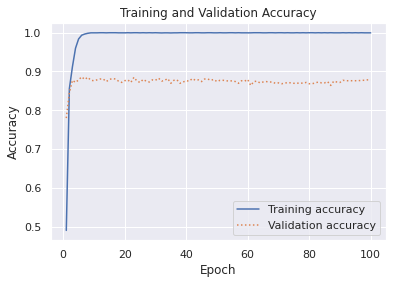

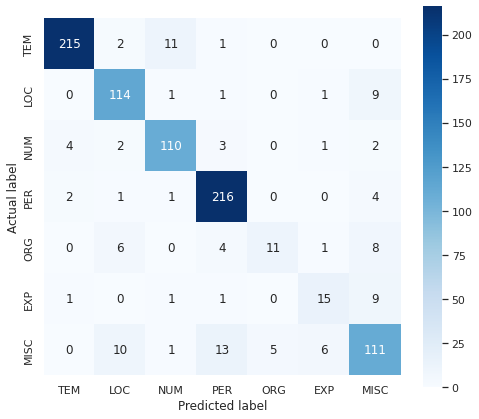

In [276]:
acc = hist.history['categorical_accuracy']
val = hist.history['val_categorical_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

from sklearn.metrics import confusion_matrix
 
y_predicted = model.predict(x_test) > 0.5


# print(y_test);
# print(y_predicted);
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1),labels=le.fit_transform(labels))
labels = ['TEM','LOC','NUM','PER','ORG','EXP','MISC']
import seaborn as sns
plt.figure(figsize=(8,7))
sns.set()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

**Fine Grained Classification Model**

In [266]:
def dnnFineGrained(coarse_type,fine_types):
  #decleration
  from keras.models import Sequential
  from keras.layers import Dense, Flatten
  from keras.layers.embeddings import Embedding
  from sklearn.model_selection import train_test_split
  output_shape=len(fine_types)
  # print(output_shape);
  subset=dataset[dataset['CoarseType']==coarse_type]
  subsetFineTypes=subset['FineType'].unique()
  # print(subsetFineTypes)
  subset= subset[subset['FineType'].isin(fine_types)]
  # print(len(subset))



  from keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(subset['Questions'])
  sequences = tokenizer.texts_to_sequences(subset['Questions'])


  from keras.preprocessing.sequence import pad_sequences
  padded_sequences = pad_sequences(sequences, maxlen=100)
  x=padded_sequences


  from sklearn import preprocessing
  from tensorflow.keras.utils import to_categorical
  le = preprocessing.LabelEncoder()
  y=subset.FineType;
  y = le.fit_transform(y)
  y = to_categorical(y) 

  #Model
  model = Sequential() 
  model.add(Embedding(10000, 32, input_length=100)) 
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(output_shape, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.summary()
  # Splitting test set
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state = 42) 
  hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=22)
  # print(len(x_test));

  #plotting
  acc = hist.history['categorical_accuracy']
  val = hist.history['val_categorical_accuracy']
  epochs = range(1, len(acc) + 1)
  # plt.figure(figsize=(8,6))
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()

  from sklearn.metrics import confusion_matrix
  
  y_predicted = model.predict(x_test)
  # print(y_test);
  # print(y_predicted);

  mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1), labels=le.fit_transform(fine_types))
  import seaborn as sns
  plt.figure(figsize=(8,7))
  ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='Blues')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Intent')
  ax.set_ylabel('Actual Intent')
  ax.xaxis.set_ticklabels(fine_types)
  ax.yaxis.set_ticklabels(fine_types)
  plt.show()
 


**Person**

Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_136 (Embedding)   (None, 100, 32)           320000    
                                                                 
 flatten_130 (Flatten)       (None, 3200)              0         
                                                                 
 dense_266 (Dense)           (None, 128)               409728    
                                                                 
 dense_267 (Dense)           (None, 4)                 516       
                                                                 
Total params: 730,244
Trainable params: 730,244
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44/44 [==============================] - 1s 16ms/step - loss: 0.4288 - categorical_accuracy: 0.9266 - val_loss: 0.3451 - val_categorical_accuracy: 0.9163
Epoch 2/100


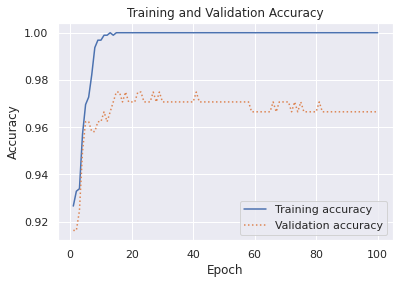

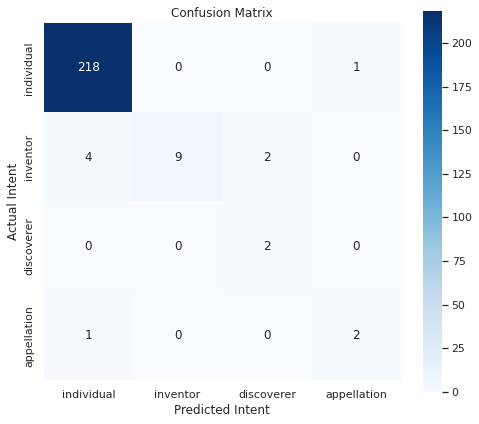

In [267]:
coarse_type='person';
# ['individual' 'inventor' 'discoverer' 'appellation' 'group' 'other']
fine_types=['individual','inventor','discoverer','appellation']
dnnFineGrained(coarse_type,fine_types)

**Organization**

Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_138 (Embedding)   (None, 100, 32)           320000    
                                                                 
 flatten_132 (Flatten)       (None, 3200)              0         
                                                                 
 dense_270 (Dense)           (None, 128)               409728    
                                                                 
 dense_271 (Dense)           (None, 3)                 387       
                                                                 
Total params: 730,115
Trainable params: 730,115
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 1s 105ms/step - loss: 1.0879 - categorical_accuracy: 0.5106 - val_loss: 1.1394 - val_categorical_accuracy: 0.3333
Epoch 2/100
3

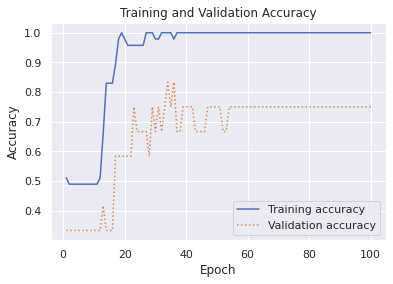

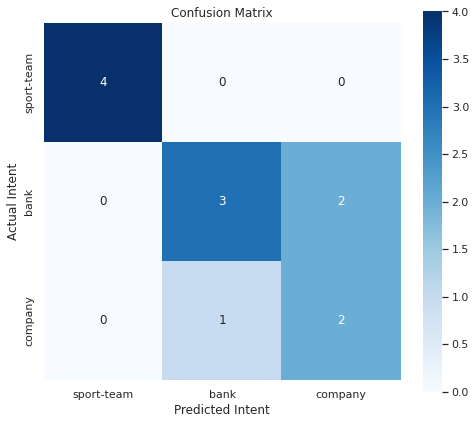

In [269]:
coarse_type='organization';
fine_types=['sport-team','bank','company']
dnnFineGrained(coarse_type,fine_types)

**Location**

Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_139 (Embedding)   (None, 100, 32)           320000    
                                                                 
 flatten_133 (Flatten)       (None, 3200)              0         
                                                                 
 dense_272 (Dense)           (None, 128)               409728    
                                                                 
 dense_273 (Dense)           (None, 7)                 903       
                                                                 
Total params: 730,631
Trainable params: 730,631
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 1s 19ms/step - loss: 1.5955 - categorical_accuracy: 0.4246 - val_loss: 1.5483 - val_categorical_accuracy: 0.4206
Epoch 2/100


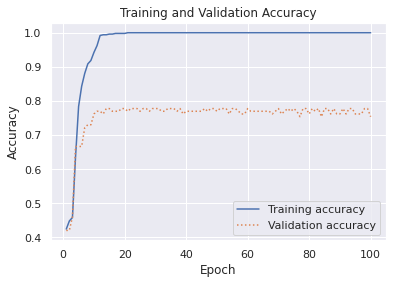

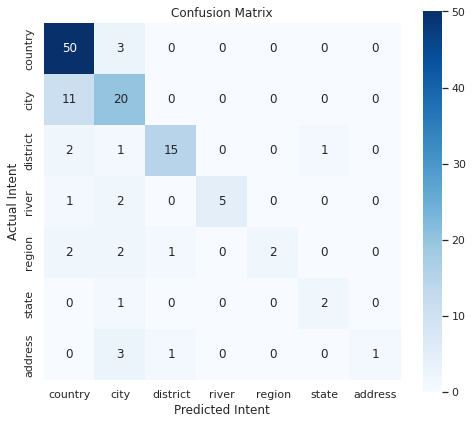

In [270]:
coarse_type='location';
fine_types=['country','city','district','river','region','state','address']
dnnFineGrained(coarse_type,fine_types)

**Temporal**

Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_140 (Embedding)   (None, 100, 32)           320000    
                                                                 
 flatten_134 (Flatten)       (None, 3200)              0         
                                                                 
 dense_274 (Dense)           (None, 128)               409728    
                                                                 
 dense_275 (Dense)           (None, 6)                 774       
                                                                 
Total params: 730,502
Trainable params: 730,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 1s 21ms/step - loss: 1.3500 - categorical_accuracy: 0.5643 - val_loss: 1.3265 - val_categorical_accuracy: 0.5619
Epoch 2/100


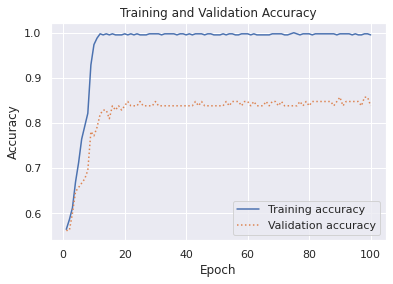

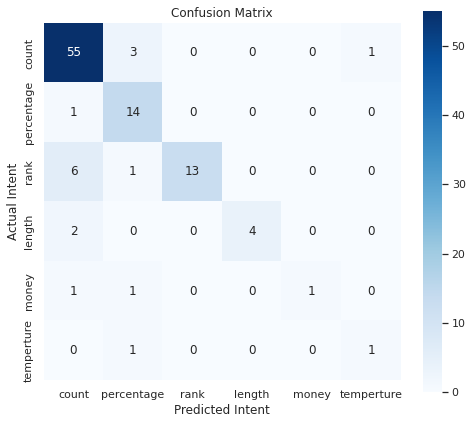

In [271]:
coarse_type='numerical';
fine_types= ['count','percentage','rank','length','money','temperture']
dnnFineGrained(coarse_type,fine_types)

**Explanation**

Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_141 (Embedding)   (None, 100, 32)           320000    
                                                                 
 flatten_135 (Flatten)       (None, 3200)              0         
                                                                 
 dense_276 (Dense)           (None, 128)               409728    
                                                                 
 dense_277 (Dense)           (None, 3)                 387       
                                                                 
Total params: 730,115
Trainable params: 730,115
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 52ms/step - loss: 0.6213 - categorical_accuracy: 0.8672 - val_loss: 0.2686 - val_categorical_accuracy: 0.9394
Epoch 2/100
6/

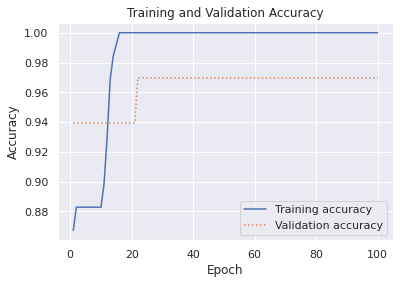

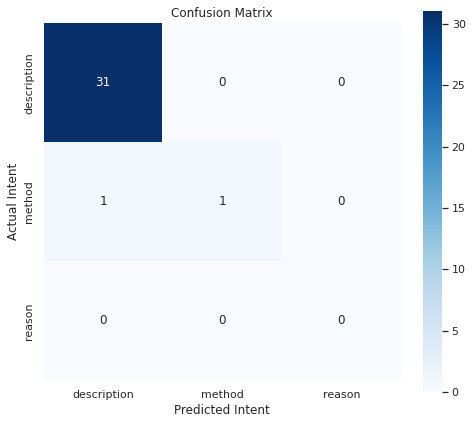

In [272]:
coarse_type='explanation';
fine_types= ['description','method','reason']
dnnFineGrained(coarse_type,fine_types)

**Miscellaneous**

Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_142 (Embedding)   (None, 100, 32)           320000    
                                                                 
 flatten_136 (Flatten)       (None, 3200)              0         
                                                                 
 dense_278 (Dense)           (None, 128)               409728    
                                                                 
 dense_279 (Dense)           (None, 10)                1290      
                                                                 
Total params: 731,018
Trainable params: 731,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 1s 35ms/step - loss: 2.1471 - categorical_accuracy: 0.2712 - val_loss: 2.0186 - val_categorical_accuracy: 0.2889
Epoch 2/100
9/

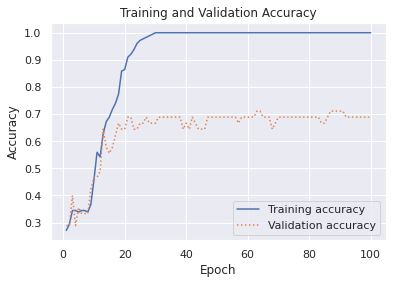

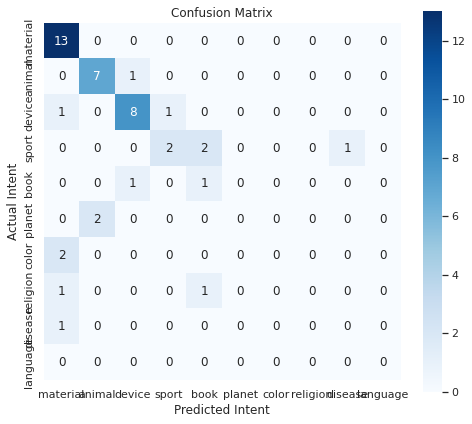

In [273]:
coarse_type='miscellaneous';
fine_types= ['material','animal','device','sport','book','planet','color','religion','disease','language']
dnnFineGrained(coarse_type,fine_types)